# CNN Interpretability Training: Feature Maps, Saliency Maps, and Grad-CAM
This notebook demonstrates interpretability techniques for Convolutional Neural Networks (CNNs) using a pre-trained ResNet18 model. We try to visualize which parts of an image contribute most to a model's decision.

In this notebook, you'll learn how to:
- Extract and visualize feature maps
- Generate saliency maps to highlight important areas in an input image
- Create Grad-CAM visualizations to understand which parts of an image activate specific layers in the model

## Step 1: Import Libraries and Initialize Model
We begin by importing the necessary libraries and loading a pre-trained CNN model, ResNet18, provided by PyTorch's `torchvision`. ResNet18 is a deep learning model with 18 layers known for high accuracy in image classification tasks.


In [16]:
# Import necessary libraries
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from captum.attr import Saliency, IntegratedGradients
import os


## Step 2: Define Helper Functions for Preprocessing and Feature Extraction
To process our image and extract insights from different layers in the model, we define the following:
- `load_image`: Preprocesses the input image for compatibility with ResNet18.
- `get_activation`: A hook function to capture intermediate activations in the network.
- `visualize_feature_maps`: Generates feature maps from specified layers, showing which parts of the image the CNN is focusing on.

We also define an output directory to store the visualizations.


In [ ]:
# Define the model and ensure it's in evaluation mode
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model.eval()

# Define output directory for saving images
output_dir = "output"
os.makedirs(output_dir, exist_ok=True)

# Preprocess input image to match ResNet's expected format
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Dictionary to hold activations
activations = {}

def load_image(image_path):
    """
    Load an image and preprocess it for the model.
    """
    img = Image.open(image_path).convert("RGB")
    img_t = preprocess(img)
    batch_t = torch.unsqueeze(img_t, 0)
    return batch_t

# Function to capture activations at specific layers
def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook


## Step 3: Register Hooks to Capture Feature Maps
We register hooks to capture activations from selected layers in the network. Each layer corresponds to different levels of feature abstraction in the model. Here, we register hooks on intermediate layers to observe how the model processes the input image at various stages.


In [18]:
# Register hooks for selected layers
model.layer2[1].register_forward_hook(get_activation('layer2_block2'))
model.layer3[1].register_forward_hook(get_activation('layer3_block2'))
model.layer4[1].register_forward_hook(get_activation('layer4_block2'))


## Step 4: Visualize Feature Maps
Feature maps are extracted from the registered layers to see which patterns are activated by the model. This helps us understand which aspects of the input the network emphasizes.

The function below visualizes and saves the feature maps from each registered layer.


In [19]:
def visualize_feature_maps(activations, layer_name):
    """
    Visualize and save feature maps from a specific layer.
    """
    layer_activations = activations[layer_name].squeeze(0).cpu().numpy()
    
    num_features = layer_activations.shape[0]
    plt.figure(figsize=(15, 15))
    for i in range(min(num_features, 16)):  # Display up to 16 feature maps
        plt.subplot(4, 4, i + 1)
        plt.imshow(layer_activations[i], cmap="viridis")
        plt.axis('off')
    plt.suptitle(f"Feature Maps in {layer_name}")

    filepath = os.path.join(output_dir, f"{layer_name}_feature_maps.png")
    plt.savefig(filepath)
    plt.show()
    plt.close()
    print(f"Saved feature maps for {layer_name} to {filepath}")


## Step 5: Saliency Map Visualization
Saliency maps highlight pixels most important to the model's decision. Using Captum's `Saliency` method, we compute the gradients of the output with respect to the input, providing a heatmap of relevant pixels.

The following function generates and saves the saliency map.


In [20]:
def saliency_map(image_tensor, target_class):
    """
    Generate and save a saliency map.
    """
    image_tensor.requires_grad = True
    
    saliency = Saliency(model)
    saliency_map = saliency.attribute(image_tensor, target=target_class)
    saliency_map = saliency_map.squeeze().cpu().numpy()
    
    plt.imshow(saliency_map[0], cmap='hot')
    plt.title("Saliency Map")
    plt.axis('off')
    
    filepath = os.path.join(output_dir, "saliency_map.png")
    plt.savefig(filepath)
    plt.show()
    print(f"Saved saliency map to {filepath}")


## Step 6: Grad-CAM Visualization
Grad-CAM (Gradient-weighted Class Activation Mapping) identifies the regions in an image that most strongly activate certain neurons, giving a more intuitive understanding of the model's focus areas.

The function below computes and visualizes a Grad-CAM heatmap.


In [21]:
def grad_cam(image_tensor, target_class):
    """
    Generate and save a Grad-CAM visualization.
    """
    gradients = {}
    def save_gradient(name):
        def hook(module, input, output):
            output.register_hook(lambda grad: gradients.update({name: grad}))
        return hook

    model.layer4[1].register_forward_hook(save_gradient('layer4_block2'))

    output = model(image_tensor)
    loss = output[0, target_class]
    loss.backward()

    gradient = gradients['layer4_block2'].squeeze(0).cpu().numpy()
    activation = activations['layer4_block2'].squeeze(0).cpu().numpy()

    weights = np.mean(gradient, axis=(1, 2))
    grad_cam_map = np.sum(weights[:, None, None] * activation, axis=0)
    grad_cam_map = np.maximum(grad_cam_map, 0)
    grad_cam_map /= grad_cam_map.max()

    plt.imshow(grad_cam_map, cmap='jet', alpha=0.5)
    plt.title("Grad-CAM")
    plt.axis('off')

    filepath = os.path.join(output_dir, "grad_cam.png")
    plt.savefig(filepath)
    plt.show()
    print(f"Saved Grad-CAM to {filepath}")


## Step 7: Run Interpretability Techniques
Finally, we load the input image, pass it through the model, and generate visualizations for feature maps, saliency maps, and Grad-CAM.


Predicted Class: 671


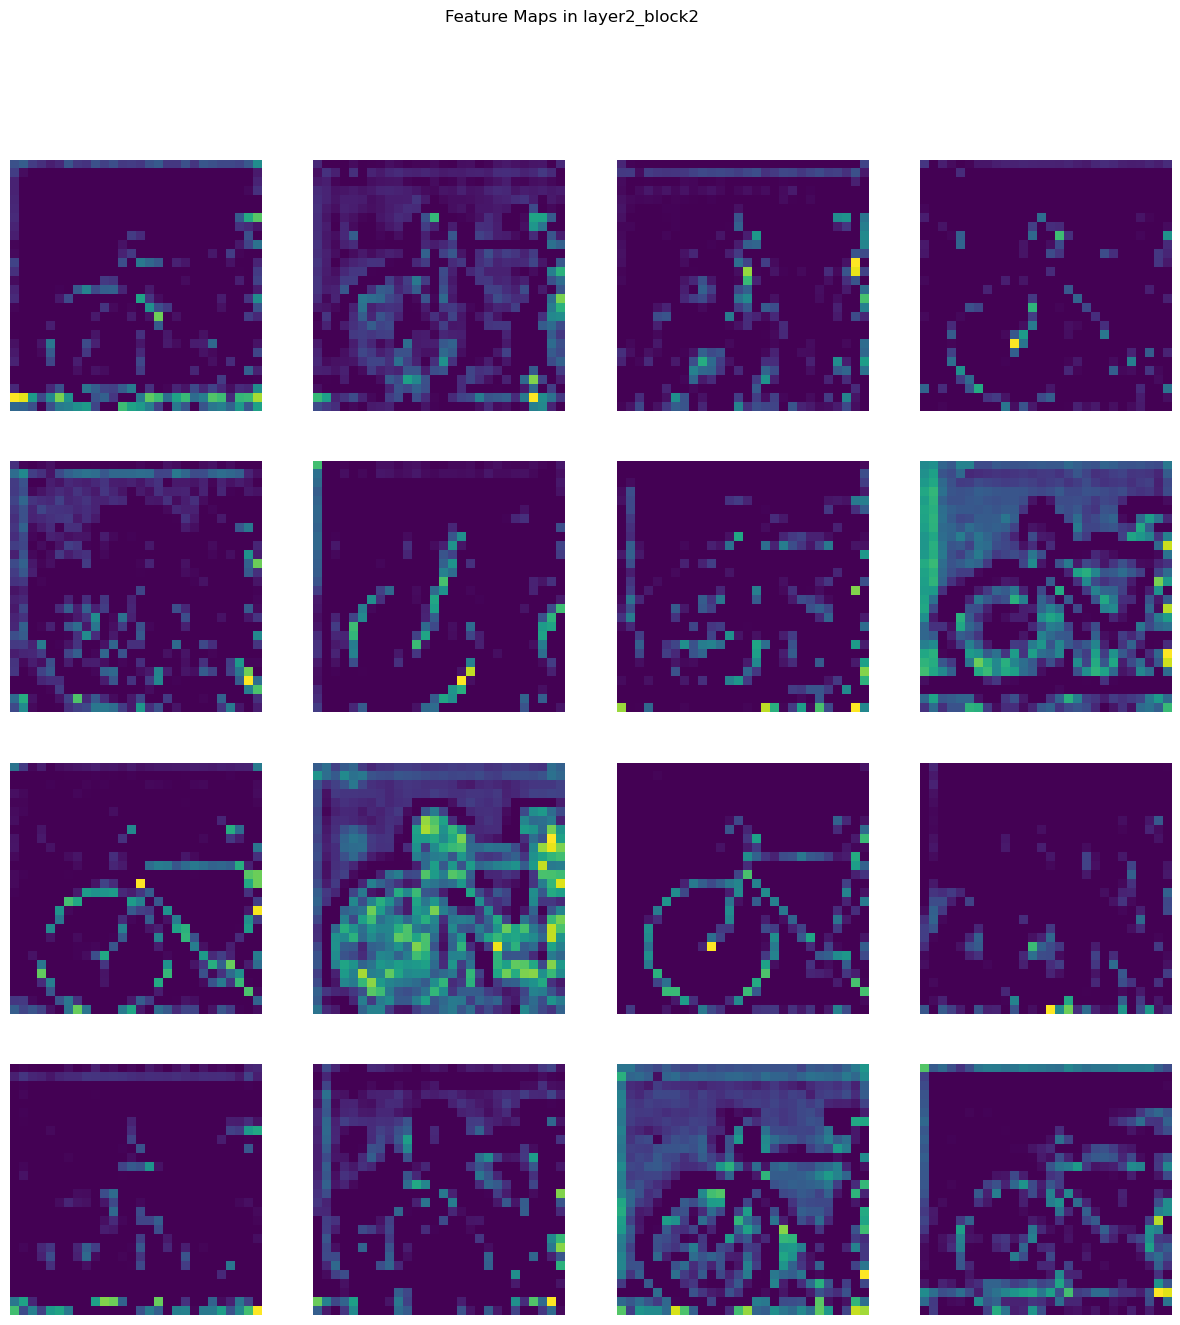

Saved feature maps for layer2_block2 to ../output/layer2_block2_feature_maps.png


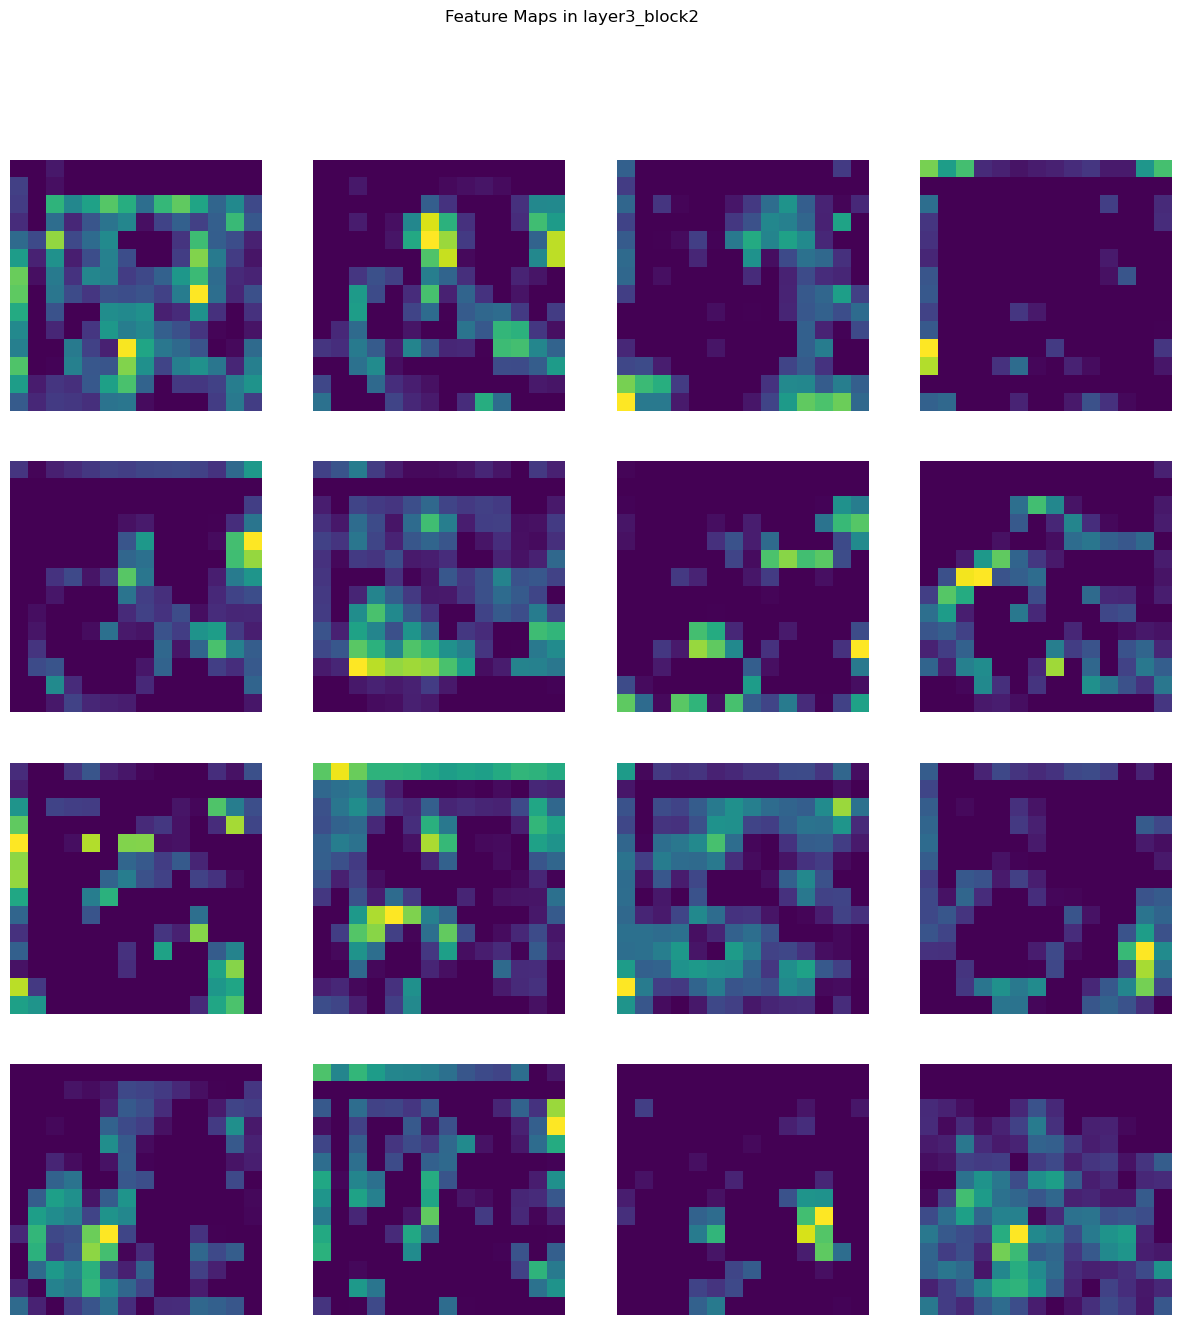

Saved feature maps for layer3_block2 to ../output/layer3_block2_feature_maps.png


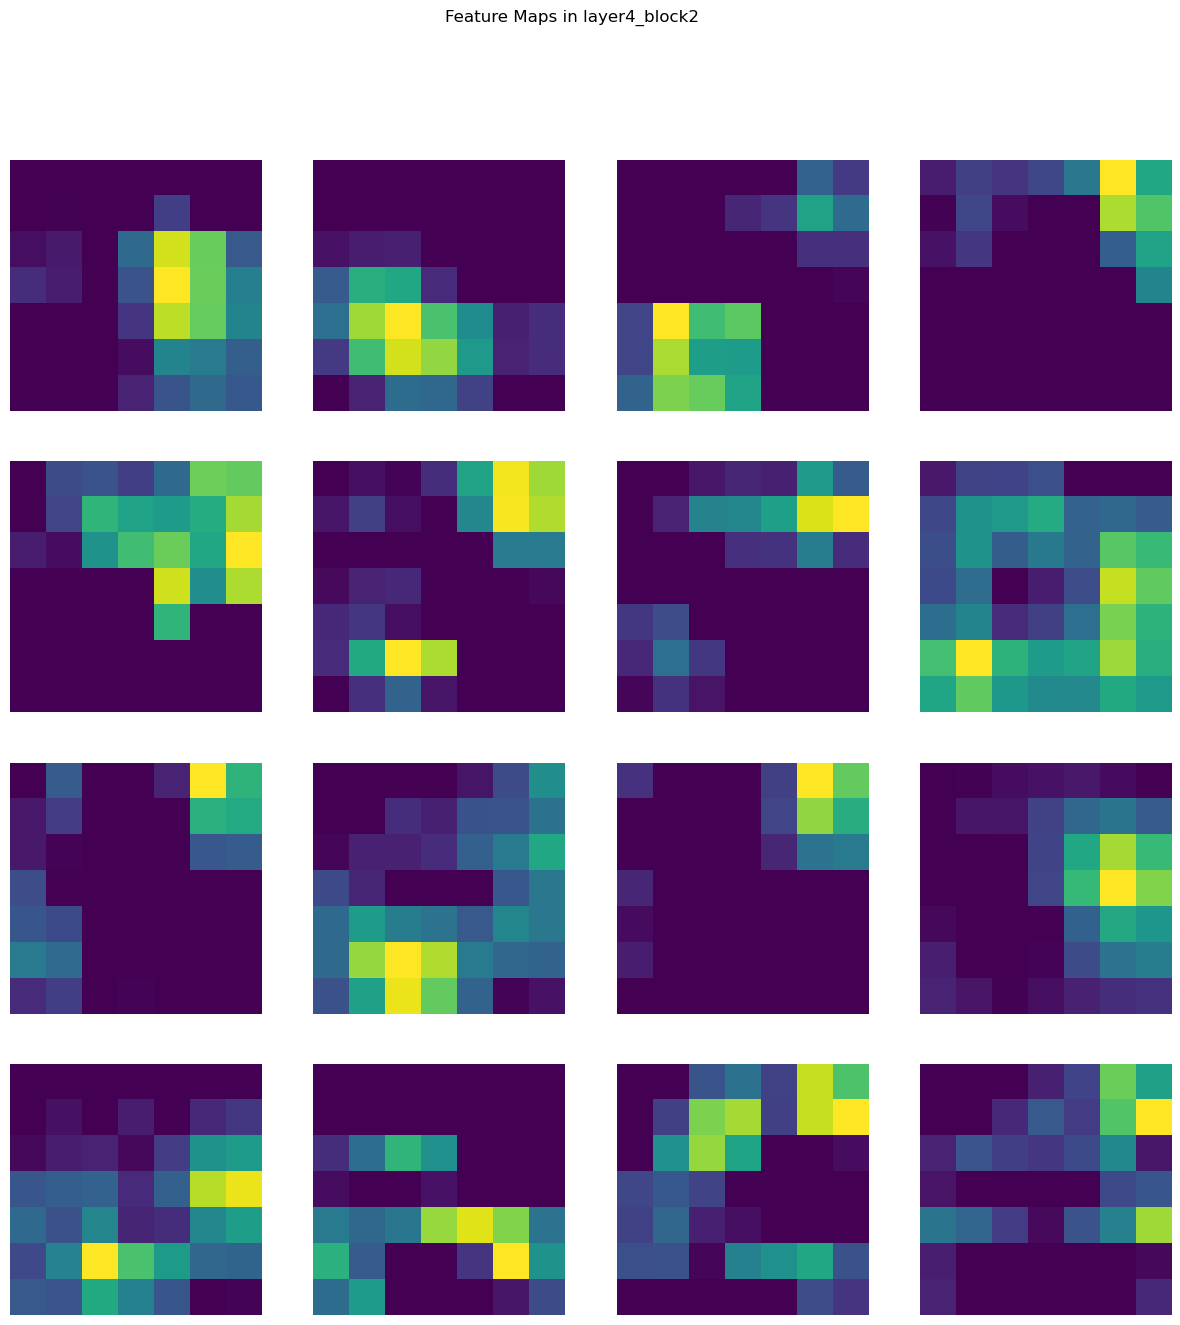

Saved feature maps for layer4_block2 to ../output/layer4_block2_feature_maps.png


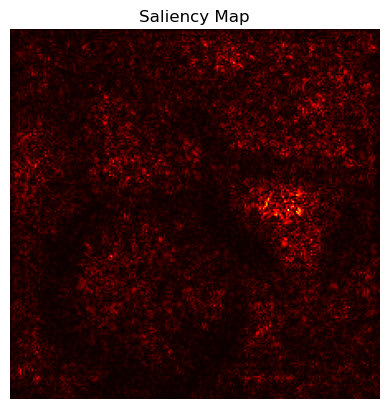

Saved saliency map to ../output/saliency_map.png


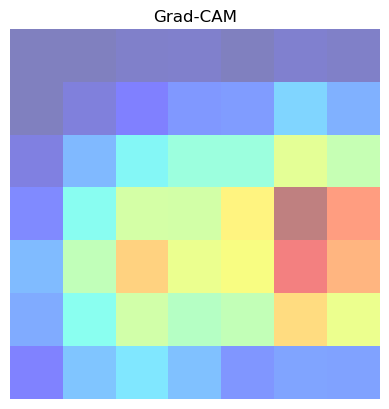

Saved Grad-CAM to ../output/grad_cam.png


In [22]:
# Load and preprocess the image
image_path = '../images/bike.jpg'
image_tensor = load_image(image_path)

# Forward pass through the model
with torch.no_grad():
    output = model(image_tensor)

# Determine the target class
target_class = output.argmax().item()
print(f"Predicted Class: {target_class}")

# Visualize feature maps for each layer
for layer_name in activations:
    visualize_feature_maps(activations, layer_name)

# Generate and save saliency map
saliency_map(image_tensor, target_class)

# Generate and save Grad-CAM map
grad_cam(image_tensor, target_class)


### Observations

Great work reaching this point! Now that you've generated feature maps, saliency maps, and Grad-CAM visualizations, here are some ideas for how to interact with and explore the results:

#### **Look for Patterns**
   - In each layer's feature maps, try to identify if certain features or parts of the image (like edges, textures, or shapes) are highlighted.  
   Earlier layers often capture basic patterns like edges, while deeper layers recognize complex shapes.
   - Check how the feature maps evolve from layer to layer.  
   Are certain layers better at highlighting specific parts of the image?  
   This can reveal which layers specialize in capturing different levels of abstraction.
   - **Experiment Around!** Change the number of feature maps displayed in the `visualize_feature_maps` function (e.g., show more or fewer than 16 maps) to see a broader or more focused view.

#### **Saliency Map**
   - Which areas of the image have the highest saliency (i.e., those highlighted in the heatmap)? 
   These regions are where the model focused most to make its decision.
   - Use different images! Check for changes.

#### **Some ideas with Grad-CAM**
   - Grad-CAM highlights the regions in the image most relevant to the predicted class.  
   Compare these regions with those identified in the saliency map. Is there a difference in what each method emphasizes?
   - The Grad-CAM visualization here uses `layer4_block2` as the target layer. Try selecting earlier layers (like `layer3_block2`) to see how the highlighted regions shift. Update the code in `grad_cam` by registering hooks on different layers.
   - Try overlaying the Grad-CAM map on the original image with different levels of transparency (`alpha`) to see how it affects clarity. Use `plt.imshow(original_image)` before `plt.imshow(grad_cam_map, cmap='jet', alpha=0.5)`.

#### **Why Not Try Different Interpretability Methods?**
   - Replace Saliency with Integrated Gradients (available in Captum) for a potentially smoother visualization. Change `Saliency` to `IntegratedGradients` in the `saliency_map` function and re-run to see if the results differ.
   - Captum includes other interpretability methods, such as `DeepLift` and `GradientShap`. Experiment with them in place of Saliency to see how each technique highlights different image regions.
   - **Different Pre-trained Model?** We use ResNet18, but you could try other architectures (e.g., VGG16, ResNet50, or even EfficientNet). Replace `models.resnet18` with other torchvision models!.
   - **Fine-Tuning?** Try fine-tuning the model on a small dataset, then visualize the interpretability maps to see if your model’s focus shifts.

Happy experimenting! By testing different inputs, classes, layers, and methods, you'll gain a deeper understanding of CNN interpretability and have some fun with AI visualization along the way!
